#SEGUNDO EXAMEN PARCIAL
---
```
Universidad Nacional de San Antonio Abad del Cusco
Asignatura: Deep Learning
Docente   : Ivan Cesar Medrano Valencia
Autor     : Etson Ronaldao Rojas Cahuana
Fecha     : 05/01/2022
Lugar     : Cusco, Perú
Proposito : Diseñar una Red Neuronal Convolucional (CNN) y entrenarla para realizar clasificación con el conjunto de datos de aves que se adjunta. 
```
---

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!unrar x "/content/drive/MyDrive/aves.rar" "/content"

Mounted at /content/drive/

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/drive/MyDrive/aves.rar

Creating    /content/valid                                            OK
Creating    /content/valid/AFRICAN FIREFINCH                          OK
Extracting  /content/valid/AFRICAN FIREFINCH/1.jpg                         0%  OK 
Extracting  /content/valid/AFRICAN FIREFINCH/2.jpg                         0%  OK 
Extracting  /content/valid/AFRICAN FIREFINCH/3.jpg                         0%  OK 
Extracting  /content/valid/AFRICAN FIREFINCH/4.jpg                         0%  OK 
Extracting  /content/valid/AFRICAN FIREFINCH/5.jpg                         0%  OK 
Creating    /content/valid/ALBATROSS                                  OK
Extracting  /content/valid/ALBATROSS/1.jpg                                 0%  OK 
Extracting  /content/valid/ALBATROSS/2.jpg                                 0%

Importar librerias necesarias

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from datetime import datetime
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import os
import numpy as np
import sys
import PIL
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

#a) Lectura y preprocesamiento de datos (generador de imágenes)

Preprocesamiento de datos

In [ ]:
datos = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/test',                                                               
                                    image_size=(224,224),
                                    batch_size=64,
                                    subset="training",
                                    shuffle=True,
                                    seed=123,
                                    validation_split=0.2
                                    )

Found 50 files belonging to 10 classes.
Using 40 files for training.


Mostrar datos

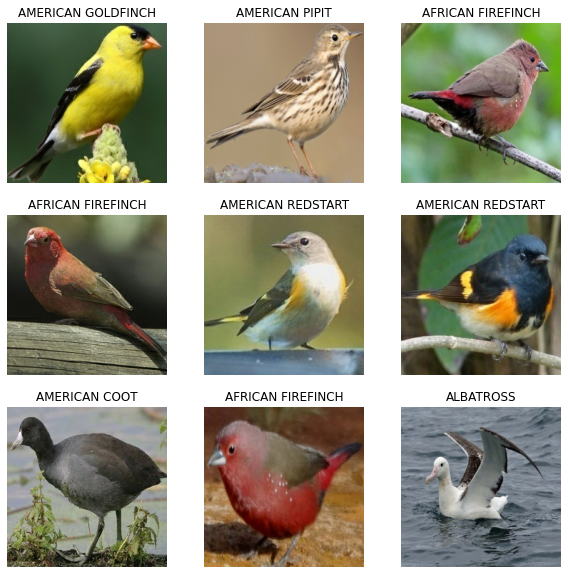

In [ ]:
nombre_clases = datos.class_names
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in datos.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(nombre_clases[labels[i]])
    plt.axis("off")

Separar datos de entrenamiento, test y validacion.

In [ ]:
#Aplicaríamos transformación de imagen para evitar problemas de sobreajuste
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True)
training_set = train_datagen.flow_from_directory(
        '/content/train',
        target_size = (224, 224),
        batch_size = 32,
        class_mode = "categorical")
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        '/content/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_set = valid_datagen.flow_from_directory(
        '/content/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 1490 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


#b) Construcción del modelo (7 ptos.)

Creacion del modelo convolucional

In [ ]:
#Crear modelo secuencial
cnn = tf.keras.models.Sequential()
#Añadir capa convolucional y un maxpool
cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu',input_shape = (224, 224, 3), padding="valid"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))
#Añadir capa convolucional y un maxpool
cnn.add(tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2))
#Aplanar las capas de convolución
cnn.add(tf.keras.layers.Flatten())
#Conecta completamente las capas
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
#Capa de salida
cnn.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))
#Mostrar resumen de modelo
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 186624)            0         
                                                                 
 dense_16 (Dense)            (None, 128)              

#c) Entrenamiento del modelo (2 ptos.)

Para el entrenamiento del modelo creado anteriormente se utilizo GPU de google colaboratory, con esto se agiliza el tiempo que se entrena pasando de 300 segundos promedio por epoca a 20 segundos promedio, se utiliza la funcion de pérdida de entropía cruzada por tener dos o más clases de etiquetas.

In [ ]:
#Compilar modelo
cnn.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy'])
#Se utiliza una activacion para una parada anticipada y evitar el sobreajuste
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
#Reducir la tasa de aprendizaje cuando el aprendizaje se estanca
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
tb = TensorBoard(log_dir = logdir)
#Entrenar el modelo cnn y guardar el historial en model
model = cnn.fit(x = training_set, validation_data = valid_set, epochs = 30, callbacks = [rlr, es, tb])

Epoch 1/30
47/47 [==============================] - 20s 422ms/step - loss: 2.2082 - accuracy: 0.3040 - val_loss: 1.4028 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 2/30
47/47 [==============================] - 20s 416ms/step - loss: 1.2547 - accuracy: 0.5872 - val_loss: 1.1872 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 3/30
47/47 [==============================] - 20s 418ms/step - loss: 0.9207 - accuracy: 0.6906 - val_loss: 1.0375 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 4/30
47/47 [==============================] - 20s 422ms/step - loss: 0.6822 - accuracy: 0.7812 - val_loss: 0.8323 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 5/30
47/47 [==============================] - 20s 417ms/step - loss: 0.6042 - accuracy: 0.7987 - val_loss: 0.7441 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 6/30
47/47 [==============================] - 20s 415ms/step - loss: 0.5456 - accuracy: 0.8114 - val_loss: 0.5790 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 7/30
47/47 [==============================] - 20s 417ms/st

Segun el entrenamiento con los datos de validacion se obtiene una precision del 0.9960 para 30 epocas.

#d) Evaluación del modelo y gráficas de entrenamiento y validación (accuracy - loss) (4 ptos.) 

Obtenemos los valores historicos de model para hacer una grafica de las funciones accuracy, train accuracy y la perdida.

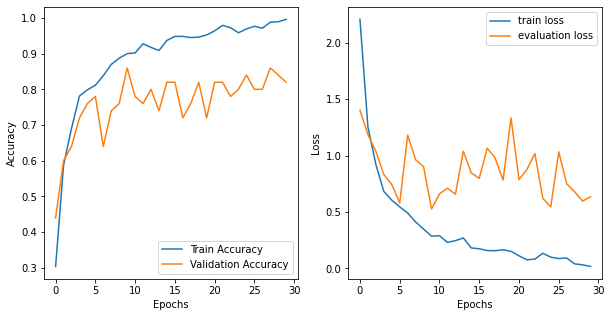

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(model.history['accuracy'], label='Train Accuracy')
ax.plot(model.history['val_accuracy'], label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(model.history['loss'], label='train loss')
ax.plot(model.history['val_loss'], label='evaluation loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

Para evaluar manualmente el desempeño con los datos de test, se itera cada carpeta extrayendo su etiqueta y guardando cada resultado en un vector, al final sacar un promedio aritmetico de todos los datos acertados con la cantidad de datos evaluados.

In [ ]:
from tensorflow.keras.preprocessing import image
species_name = ['AFRICAN FIREFINCH','ALBATROSS','ALEXANDRINE PARAKEET','AMERICAN AVOCET','AMERICAN BITTERN',
         'AMERICAN COOT','AMERICAN GOLDFINCH','AMERICAN KESTREL','AMERICAN PIPIT','AMERICAN REDSTART']
temp = []
for bird_specy in species_name:
    for i in range(1, 6):
        test_image = image.load_img('/content/test/{}/{}.jpg'.format(bird_specy, i), target_size = (224, 224))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = cnn.predict(test_image / 255.0)
        max_index = np.where((result == np.amax(result))[0])[0][0]
        predicted_species = species_name[max_index]
        if predicted_species == bird_specy:
            temp.append(1)
        else:
            temp.append(0)
accuracy = np.sum(temp) / len(temp)
print('===EVALUACION CON LOS DATOS DE TEST===')
print('Datos acertados:',  np.sum(temp))
print('Total de datos:', len(temp))
print('Precision: ', accuracy)

===EVALUACION CON LOS DATOS DE TEST===
Datos acertados: 46
Total de datos: 50
Precision:  0.92


#e) Predicciones con el modelo entrenado (4 ptos.)

Para predecir, mostraremos las imagenes con la clase que pertenece y la prediccion que resulta.

============== AFRICAN FIREFINCH =======================


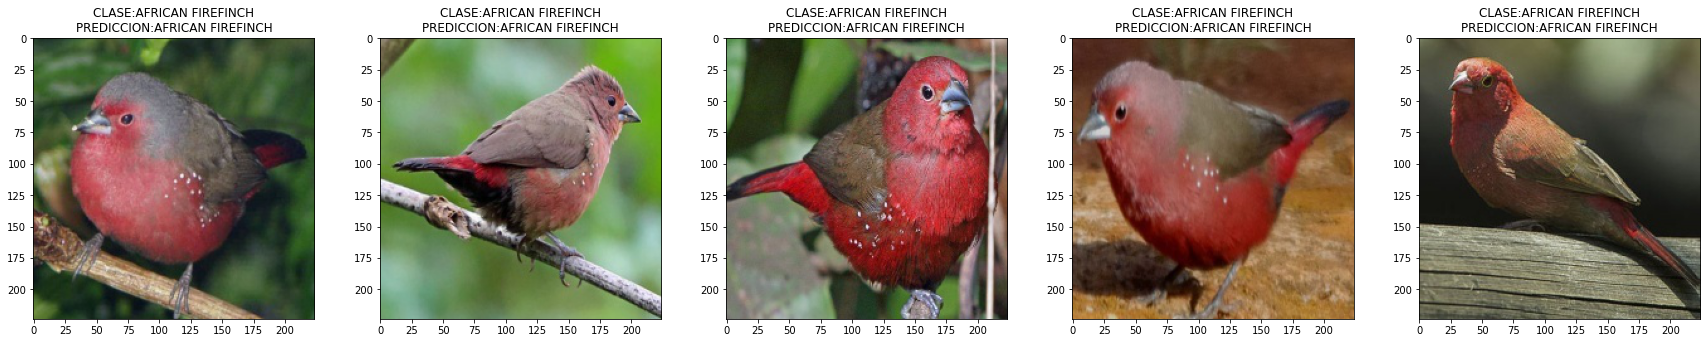

============== ALBATROSS =======================


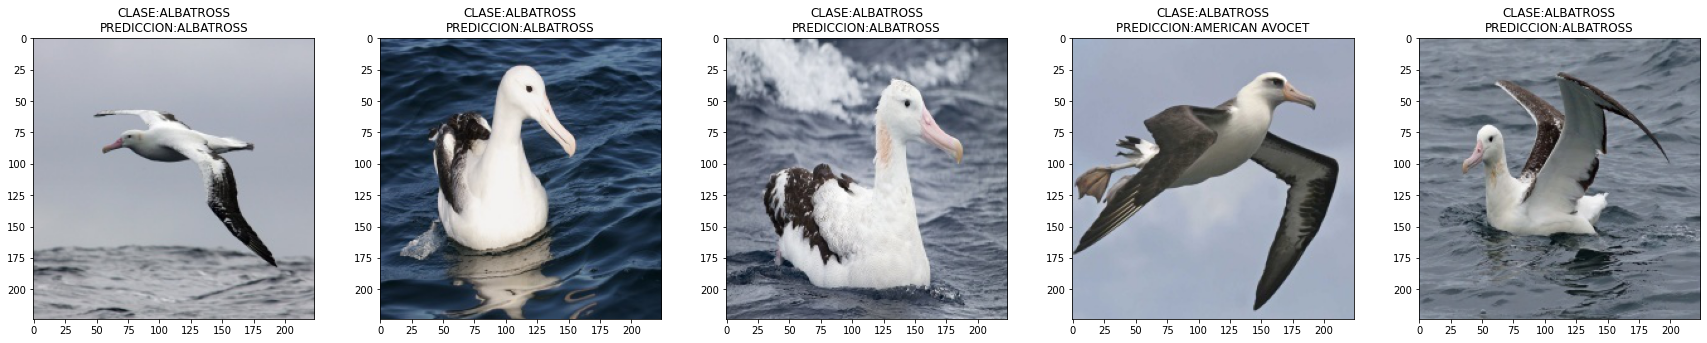

============== ALEXANDRINE PARAKEET =======================


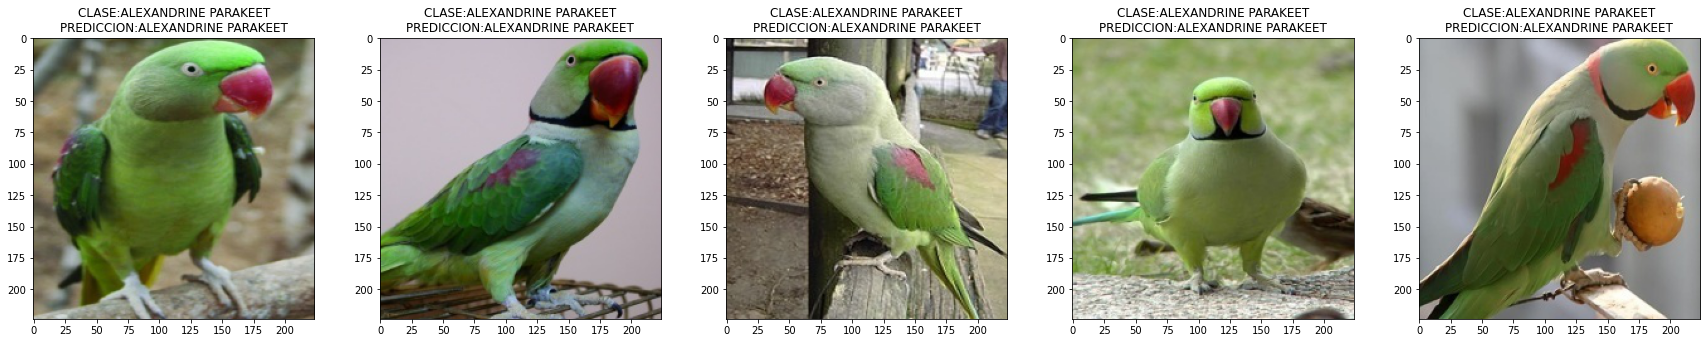

============== AMERICAN AVOCET =======================


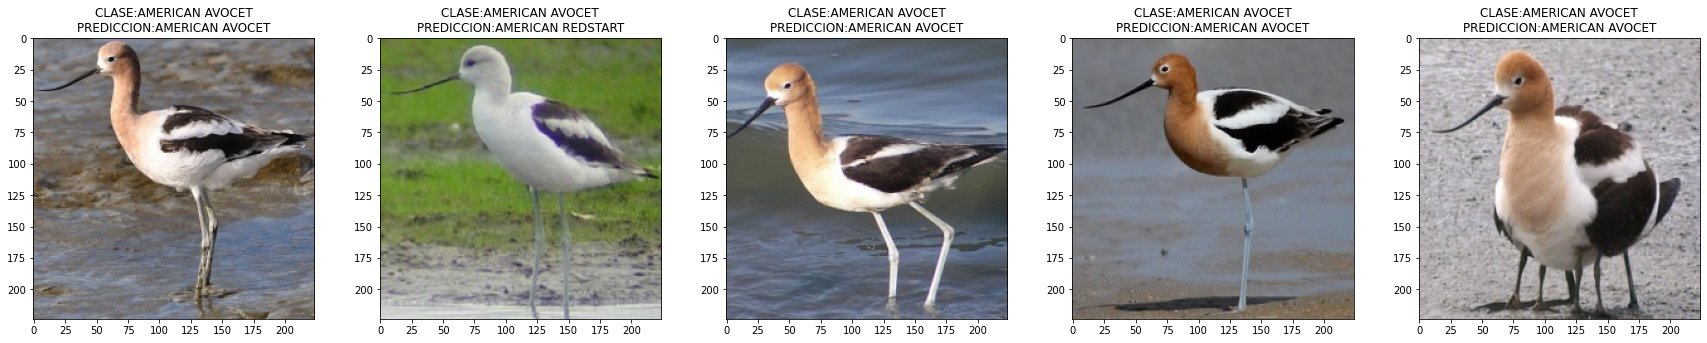

============== AMERICAN BITTERN =======================


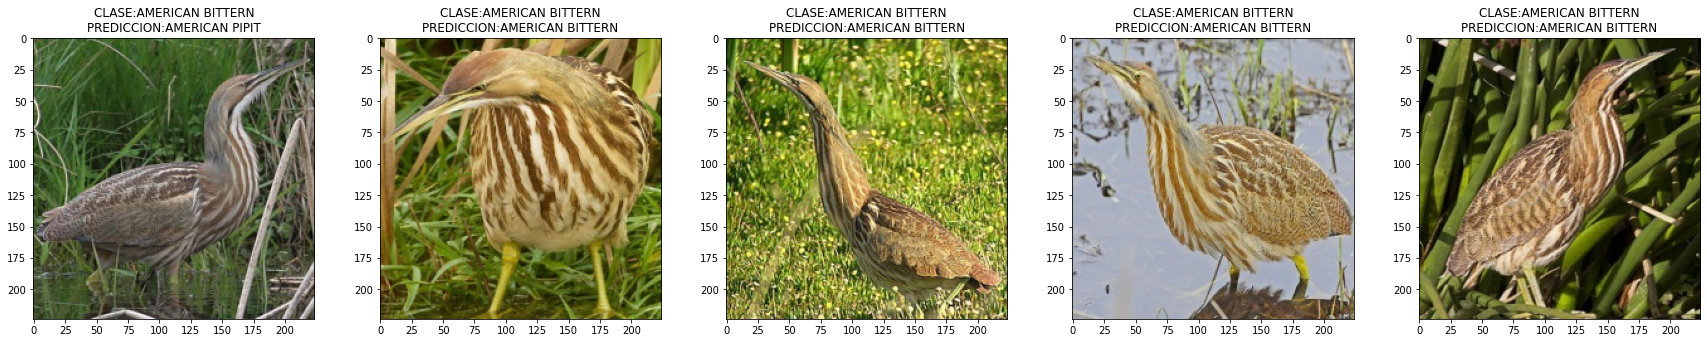

============== AMERICAN COOT =======================


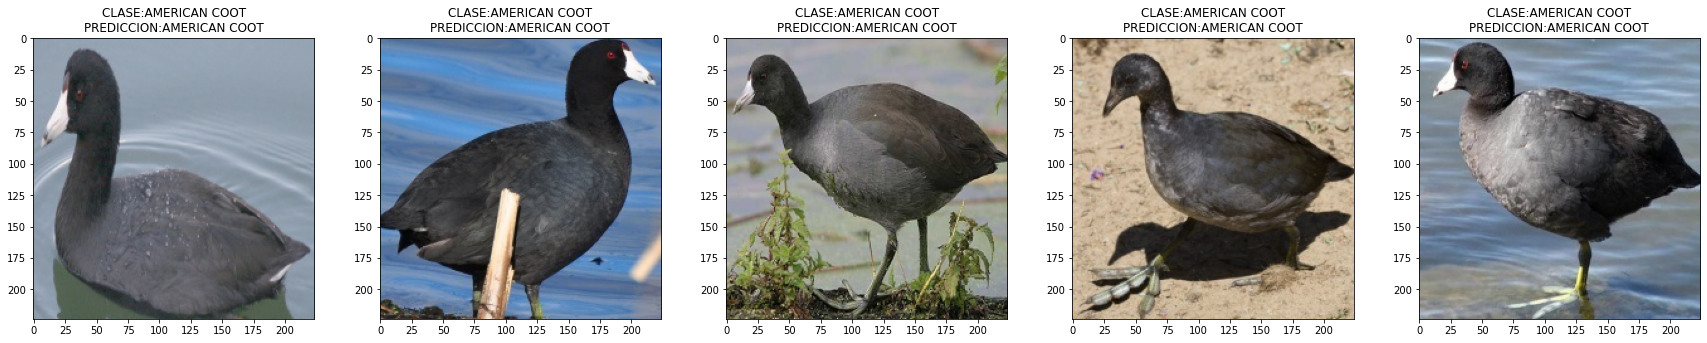

============== AMERICAN GOLDFINCH =======================


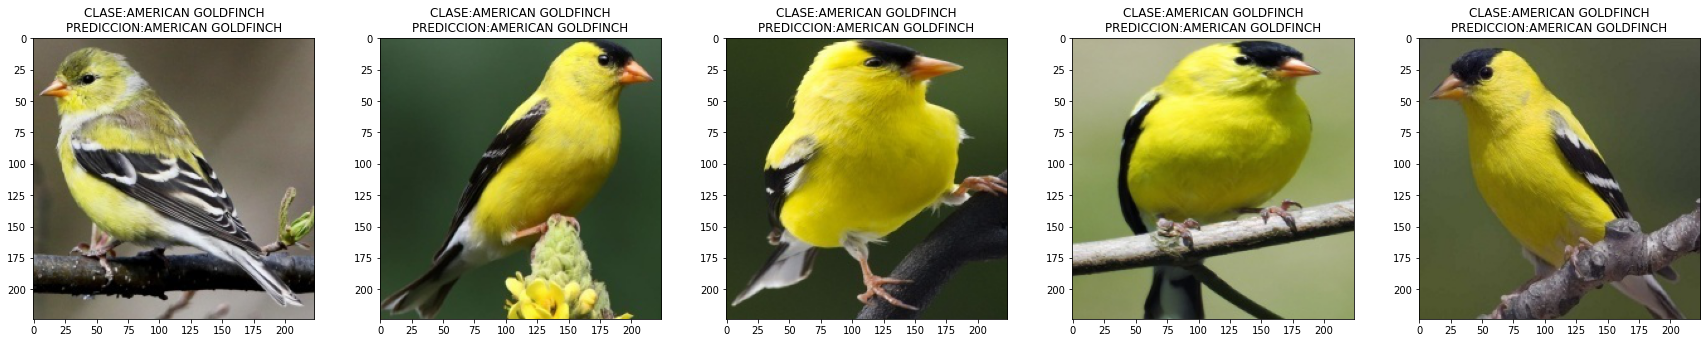

============== AMERICAN KESTREL =======================


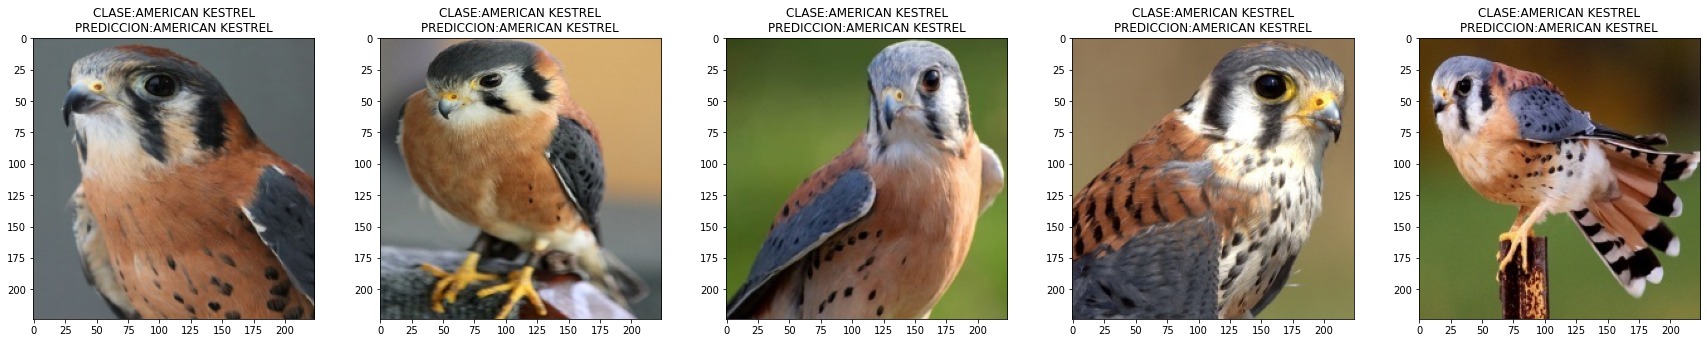

============== AMERICAN PIPIT =======================


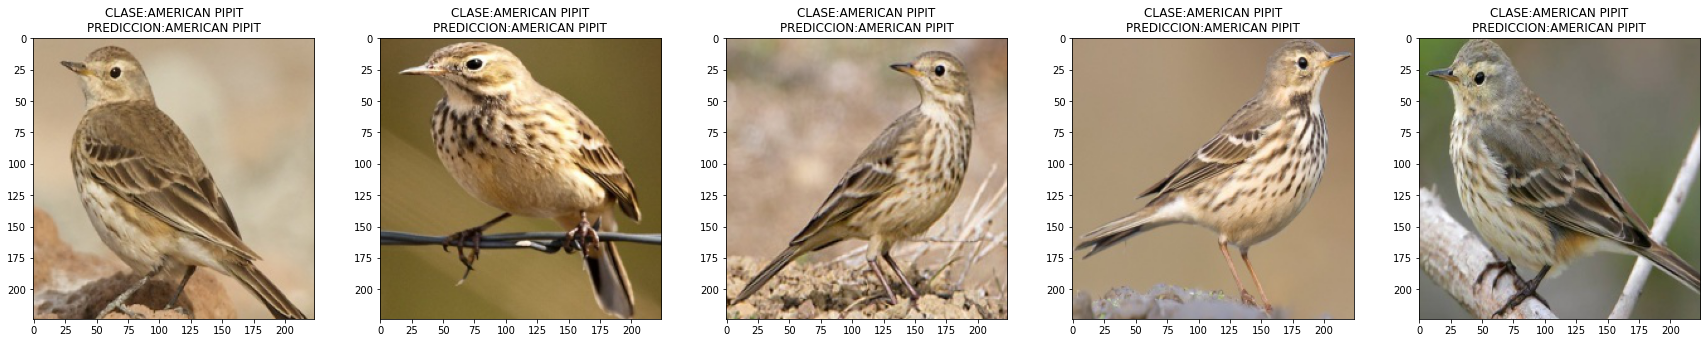

============== AMERICAN REDSTART =======================


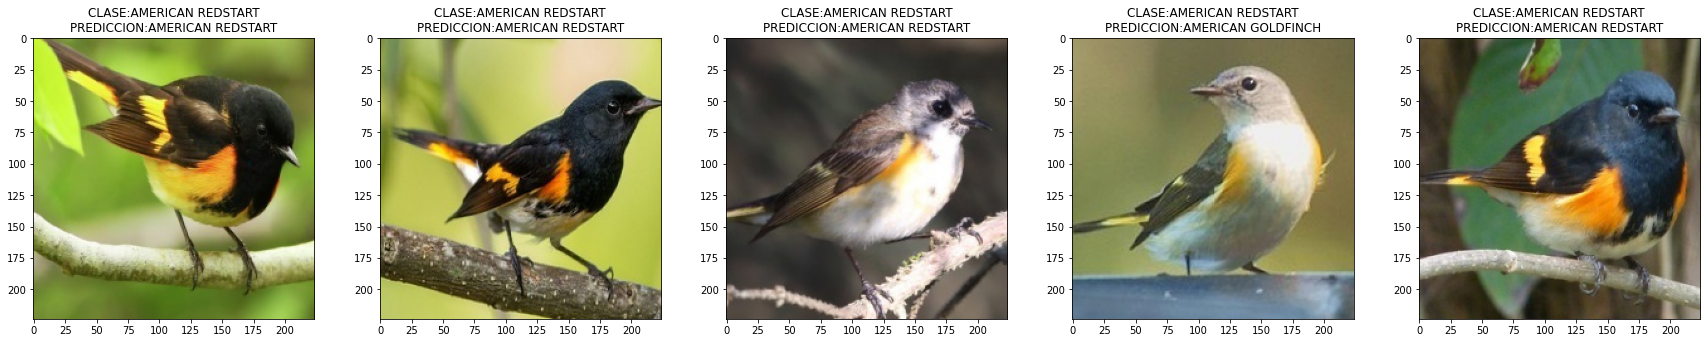

In [ ]:
#Cargar datos a utilizar
for bird_specy in species_name:
    plt.figure(figsize=(30,30))
    for i in range(1, 6):  
        plt.subplot(5,5,(i-1)+1) 
        plt.grid(False)
        test_image = image.load_img('/content/test/{}/{}.jpg'.format(bird_specy, i), target_size = (224, 224))
        plt.imshow(test_image)    
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = cnn.predict(test_image / 255.0)
        max_index = np.where((result == np.amax(result))[0])[0][0]
        predicted_species = species_name[max_index]
        plt.title('CLASE:'+bird_specy+'\nPREDICCION:'+predicted_species) 
    print('==============',bird_specy,'=======================')
    plt.show() 